In [1]:
import sys
sys.path.append('..')
import torch
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [4, 4]

from engression import engression
# from engression import engression_bagged
from engression.data.simulator import preanm_simulator

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Simulate data


In [3]:
x, y = preanm_simulator('square', n=10000, x_lower=0, x_upper=2, noise_std=1, train=True, device=device)
x_eval, y_eval_med, y_eval_mean = preanm_simulator('square', n=1000, x_lower=0, x_upper=4, noise_std=1, train=False, device=device)

## Engression

In [4]:
# Build an engression model and train
engressor = engression(x, y, lr=0.01, num_epoches=500, batch_size=1000, device=device)

Running on CPU.

Data is standardized during training only; the printed training losses are on the standardized scale, 
while during evaluation, the predictions, evaluation metrics, and plots will be on the original scale.

Training based on mini-batch gradient descent with a batch size of 1000.
[Epoch 1 (0%), batch 10]: energy-loss: 0.4571,  E(|Y-Yhat|): 1.0038,  E(|Yhat-Yhat'|): 1.0934
[Epoch 100 (20%), batch 10]: energy-loss: 0.3785,  E(|Y-Yhat|): 0.8071,  E(|Yhat-Yhat'|): 0.8573
[Epoch 200 (40%), batch 10]: energy-loss: 0.4529,  E(|Y-Yhat|): 0.8653,  E(|Yhat-Yhat'|): 0.8248
[Epoch 300 (60%), batch 10]: energy-loss: 0.3863,  E(|Y-Yhat|): 0.8130,  E(|Yhat-Yhat'|): 0.8534
[Epoch 400 (80%), batch 10]: energy-loss: 0.4229,  E(|Y-Yhat|): 0.8462,  E(|Yhat-Yhat'|): 0.8465
[Epoch 500 (100%), batch 10]: energy-loss: 0.4664,  E(|Y-Yhat|): 0.8657,  E(|Yhat-Yhat'|): 0.7985

Training loss on the original (non-standardized) scale:
	Energy-loss: 0.6372,  E(|Y-Yhat|): 1.2603,  E(|Yhat-Yhat'|): 1.24

In [5]:
engressor.summary()

Engression model with
	 number of layers: 2
	 hidden dimensions: 100
	 noise dimensions: 100
	 number of epochs: 500
	 batch size: 1000
	 learning rate: 0.01
	 standardization: True
	 training mode: False
	 device: cpu

Training loss (original scale):
	 energy-loss: 0.64, 
	E(|Y-Yhat|): 1.26, 
	E(|Yhat-Yhat'|): 1.25


In [6]:
# Evaluation
print("L2 loss:", engressor.eval_loss(x_eval, y_eval_mean, loss_type="l2"))
print("correlation between predicted and true means:", engressor.eval_loss(x_eval, y_eval_mean, loss_type="cor"))

L2 loss: 0.07565824687480927
correlation between predicted and true means: 0.9952852725982666


In [7]:
# Predictions
y_pred = engressor.predict(x_eval, target="mean")

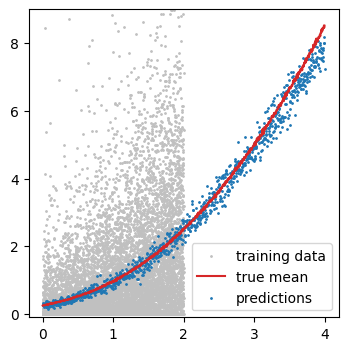

In [8]:
plt.scatter(x.cpu(), y.cpu(), label='training data', s=1, color='silver')
plt.plot(x_eval.cpu(), y_eval_mean.cpu(), label='true mean', color='C3')
plt.scatter(x_eval.cpu(), y_pred.cpu(), label='predictions', s=1)
plt.ylim(-0.1, 9)
plt.legend(); plt.show()

## Baseline: $L_2$ regression

In [9]:
from engression.models import Net

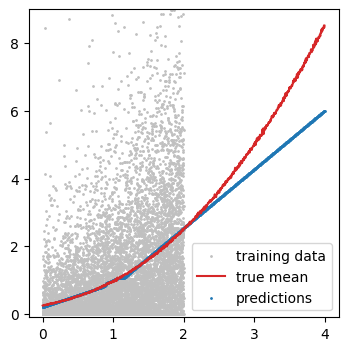

In [10]:
# Build a model with the same architecture
model = Net(num_layer=2, hidden_dim=100) # NN with the same architecture
opt = torch.optim.Adam(model.parameters(), lr=0.01) # same optimizer

# L2 regression training
model.train()
for i in range(500):
    model.zero_grad()
    y_pred = model(x)
    loss = (y_pred - y).pow(2).mean()
    loss.backward()
    opt.step()

# Evaluation
model.eval()
y_pred = model(x_eval).detach()
plt.scatter(x.cpu(), y.cpu(), label='training data', s=1, color='silver')
plt.plot(x_eval.cpu(), y_eval_mean.cpu(), label='true mean', color='C3')
plt.scatter(x_eval.cpu(), y_pred.cpu(), label='predictions', s=1)
plt.ylim(-0.1, 9)
plt.legend(); plt.show()